# From the github repo

In [ ]:
import pickle
import numpy as np
from matplotlib import pyplot as plt
from time import sleep

# Linien imports
from linien_client.device import Device
from linien_client.connection import LinienClient
from linien_common.common import AutolockMode
from linien_common.common import  MHz, Vpp, ANALOG_OUT_V

# --------------------------------------------------------------------
# Matplotlib Inline Patch — fixes AttributeError on rcParams._get
# --------------------------------------------------------------------
import matplotlib as mpl
if not hasattr(mpl.rcParams, "_get"):
    mpl.rcParams._get = mpl.rcParams.get
# --------------------------------------------------------------------

#import matplotlib
#matplotlib.use("TkAgg")  # or "Qt5Agg"

# ----------------------------------------------
# Connection setup
# ----------------------------------------------
dev = Device(
    host="192.168.1.159",  # IP address of your Red Pitaya
    username="root",
    password="root"
)

c = LinienClient(dev)
c.connect(autostart_server=True, use_parameter_cache=True)

# Choose autolock algorithm:
#   AutolockMode.SIMPLE  -> CPU-based, faster but less robust
#   AutolockMode.ROBUST  -> FPGA-based, slower startup but stable
c.parameters.autolock_mode_preference.value = AutolockMode.ROBUST
sleep(1)  # optional short delay to ensure the setting is applied

# ----------------------------------------------
# Helper: wait until laser is locked/unlocked
# ----------------------------------------------
def wait_for_lock_status(should_be_locked):
    """Wait until the laser reaches the desired lock state."""
    counter = 0
    while True:
        to_plot = pickle.loads(c.parameters.to_plot.value)
        is_locked = "error_signal" in to_plot

        if is_locked == should_be_locked:
            break

        counter += 1
        if counter > 10:
            raise Exception("waited too long")

        sleep(1)


# ----------------------------------------------
# Main autolock procedure
# ----------------------------------------------

# Turn off the lock (if currently running)
c.connection.root.start_sweep()
c.parameters.modulation_frequency.value = 0.05*MHz
c.parameters.modulation_amplitude.value = 0.1*Vpp
c.connection.root.write_registers()

linien_client.connection       INFO     Try to connect to 192.168.1.159:18862
linien_client.connection       DEBUG    Sent authentication hash
linien_client.connection       INFO     Connection established!


In [184]:
c.parameters.modulation_frequency.value = 0.05*MHz
c.connection.root.write_registers()

In [203]:
c.parameters.modulation_amplitude.value = 0.1*Vpp
c.connection.root.write_registers()

In [147]:
c.parameters.demodulation_phase_a.value = 160
c.connection.root.write_registers()

In [179]:
c.parameters.filter_1_frequency_a.value = 8000
c.parameters.filter_2_frequency_a.value = 4000
c.connection.root.write_registers()

In [217]:
c.parameters.check_for_changed_parameters()

mod_freq_raw = c.parameters.modulation_frequency.value
mod_freq = mod_freq_raw/MHz
print(f"Modulation frequency: {mod_freq} MHz")

mod_ampl_raw = c.parameters.modulation_amplitude.value
mod_ampl = mod_ampl_raw/Vpp
print(f"Modulation amplitude: {mod_ampl} Vpp")

demod_phase = c.parameters.demodulation_phase_a.value
print(f"Demodulation phase: {demod_phase} degrees")

demod_filter_1 = c.parameters.filter_1_frequency_a.value
print(f"Demodulation filter 1: {demod_filter_1} Hz")

demod_filter_2 = c.parameters.filter_2_frequency_a.value
print(f"Demodulation filter 2: {demod_filter_2} Hz")

Modulation frequency: 0.05 MHz
Modulation amplitude: 0.1 Vpp
Demodulation phase: 150.0 degrees
Demodulation filter 1: 10000.0 Hz
Demodulation filter 2: 10000.0 Hz


In [ ]:
from linien_server.parameters import save_parameters

dict_keys(['error_signal_1', 'error_signal_1_quadrature', 'monitor_signal', 'slow_control_signal'])


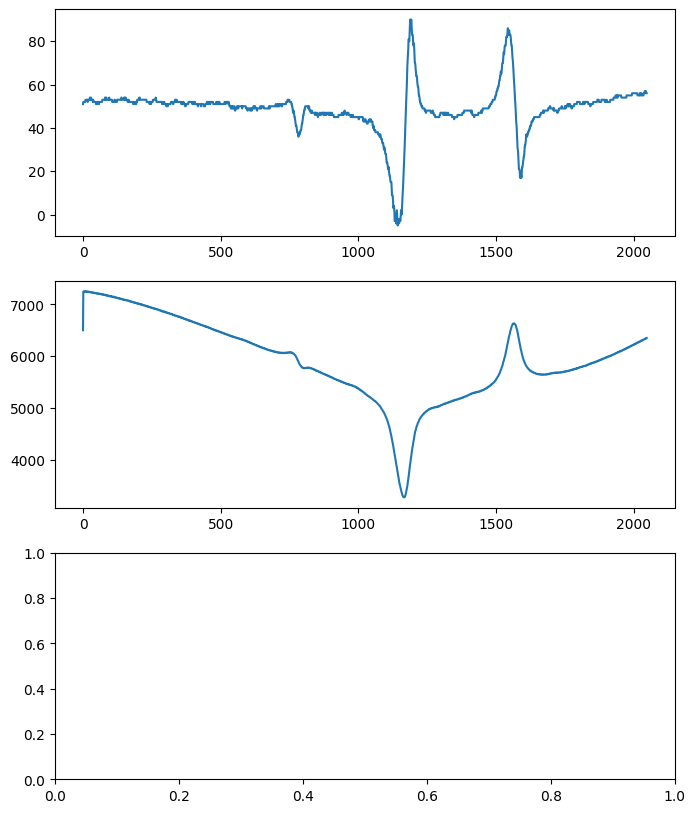

In [3]:

# Wait until the laser is unlocked
wait_for_lock_status(False)

# Record a reference spectrum
to_plot = pickle.loads(c.parameters.to_plot.value)

print(to_plot.keys())

fig,ax = plt.subplots(3,1, figsize=(8, 10))
ax[0].plot(to_plot["error_signal_1"], label="error_signal_1")
#ax[0].set_ylim(-150,150)
ax[1].plot(to_plot["monitor_signal"], label="monitor_signal_1")

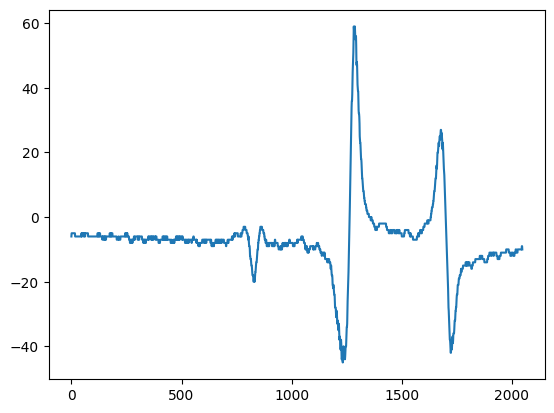

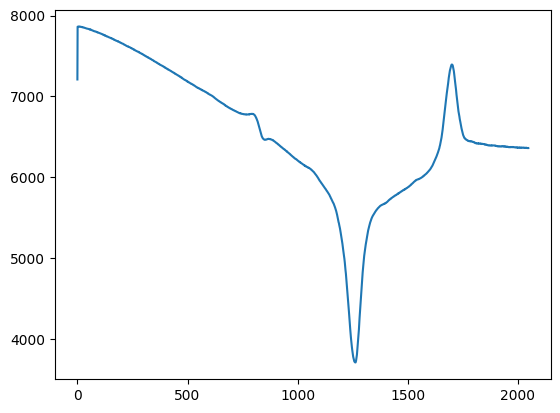

Please specify the position of the target line.


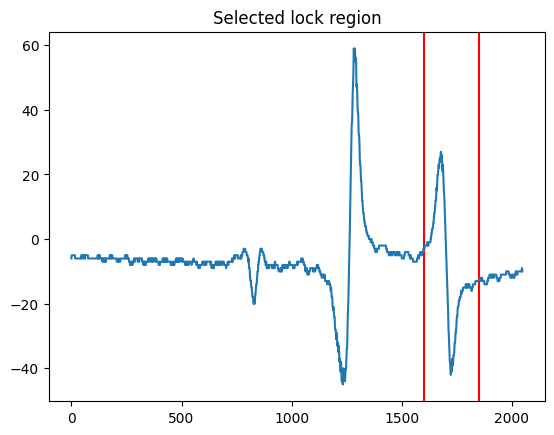

Selected region: 1600–1850 of 2048 points
Locking the laser worked! \o/


In [209]:

# Wait until the laser is unlocked
wait_for_lock_status(False)

# Record a reference spectrum
to_plot = pickle.loads(c.parameters.to_plot.value)
error_signal = to_plot["error_signal_1"]

# Plot the reference and monitor signals with two y-axes
plt.plot(error_signal)
plt.show()
plt.plot(to_plot["monitor_signal"])
plt.show()

# Ask user for target line region
print("Please specify the position of the target line.")
x0 = int(input("Enter index of a point on the LEFT side of the target line: "))
x1 = int(input("Enter index of a point on the RIGHT side of the target line: "))

# Visualize selected lock region
plt.axvline(x0, color="r")
plt.axvline(x1, color="r")
plt.plot(error_signal)
plt.title("Selected lock region")
plt.show()

# Start autolock with selected region

signal_len = len(error_signal)
print(f"Selected region: {x0}–{x1} of {signal_len} points")

if not (0 <= x0 < x1 <= signal_len):
    raise ValueError("Invalid region: indices outside range or reversed")

if x1 - x0 < 10:
    raise ValueError("Selected region too narrow — pick a wider range")

#sleep(2)

c.connection.root.start_autolock(x0, x1, pickle.dumps(error_signal))

# Wait until laser is actually locked
max_tries = 3
i = 0
try:
    wait_for_lock_status(True)
    print("Locking the laser worked! \\o/")
except Exception:
    #if i < max_tries:
        #i += 1
        #print("Locking the laser failed :(, trying again...")
        #c.connection.root.start_autolock(x0, x1, pickle.dumps(error_signal))
    #else:
    print("Locking the laser failed :(, no more tries left.") #to indent
    c.connection.root.start_sweep() #to indent

In [210]:
c.connection.root.start_sweep()

In [218]:
params = c.parameters
for name, param in vars(params).items():
    # Only pick those attributes that are actual Linien parameters
    if hasattr(param, "value"):
        print(f"{name}: {param.value}")

_async_changed_parameters_queue: [('ping', 3921)]
to_plot: b'\x80\x04\x95*1\x00\x00\x00\x00\x00\x00}\x94(\x8c\x0eerror_signal_1\x94\x8c\x15numpy.core.multiarray\x94\x8c\x0c_reconstruct\x94\x93\x94\x8c\x05numpy\x94\x8c\x07ndarray\x94\x93\x94K\x00\x85\x94C\x01b\x94\x87\x94R\x94(K\x01M\x00\x08\x85\x94h\x05\x8c\x05dtype\x94\x93\x94\x8c\x02i2\x94\x89\x88\x87\x94R\x94(K\x03\x8c\x01<\x94NNNJ\xff\xff\xff\xffJ\xff\xff\xff\xffK\x00t\x94b\x89B\x00\x10\x00\x00;\x00:\x00:\x00:\x00:\x00:\x00:\x00:\x00:\x00:\x00:\x00:\x00:\x00:\x00:\x00;\x00;\x00;\x00;\x00;\x00;\x00;\x00;\x00;\x00;\x00;\x00;\x00;\x00;\x00;\x00<\x00<\x00<\x00;\x00;\x00;\x00;\x00;\x00;\x00:\x00:\x00:\x00:\x00:\x00:\x00:\x009\x009\x009\x009\x00:\x00:\x00:\x00:\x00:\x00:\x00:\x00:\x00:\x00:\x00:\x00:\x00:\x009\x009\x009\x00:\x00:\x00:\x00:\x00;\x00;\x00;\x00;\x00;\x00;\x00;\x00;\x00;\x00<\x00<\x00<\x00<\x00<\x00<\x00<\x00<\x00<\x00<\x00<\x00<\x00<\x00<\x00<\x00<\x00<\x00<\x00<\x00<\x00<\x00<\x00;\x00;\x00;\x00;\x00;\x00;\x00;\x00:\x00:\x

In [46]:
counter = 0
limit = 3

while True:

    if counter >= limit:
        break

    counter +=1

    # Fetch the most recent data again after locking
    plot_data = pickle.loads(c.parameters.to_plot.value)

    plt.clf()

    if c.parameters.lock.value:
        plt.figure(figsize=(10, 6))
        plt.title("Laser locked — check signals")
        plt.plot(plot_data["control_signal"], label="Control signal")
        plt.plot(plot_data["error_signal"], label="Error signal")

    # Optional: plot the monitor signal if available
    if "monitor_signal" in plot_data:
        plt.plot(plot_data["monitor_signal"], label="Monitor signal", linestyle="--")

    else:
        plt.figure(figsize=(10, 6))
        plt.title("Laser sweeping/unlocked")
        plt.plot(plot_data["error_signal_1"], label="Error signal ch1")
        plt.plot(plot_data["error_signal_2"], label="Error signal ch2")

        # Again, include monitor signal if present
        if "monitor_signal" in plot_data:
            plt.plot(plot_data["monitor_signal"], label="Monitor signal", linestyle="--")

    plt.legend()
    plt.xlabel('Sample index')
    plt.ylabel('Amplitude (arb. units)')
    plt.grid(True)
    plt.show()

    sleep(1)